#Balancing our dataset attempt 

in this notebook I will attempt to balance my dataset using images that I have collected from vidoes online and by my friends to increase the frequency of some classes then I will build a neural network right from the start 




In [1]:
from google.colab import drive 
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:

import os 
import numpy as np
from skimage.io import imread
import tensorflow.keras as keras
import matplotlib.pyplot as plt 
%matplotlib inline 
import pandas as pd 
from tqdm import tqdm 
import cv2
from statistics import median
from tensorflow.keras.models import Sequential 
import h5py
import tensorflow as tf 
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ModelCheckpoint 
import tensorflow.keras.preprocessing.image as kp 
import tensorflow.keras.layers as L 
import pickle
import math

In [3]:
base="/content/drive/My Drive/model2/"
labels=pd.read_csv(base +"df.csv")
labels.drop("user.id",axis=1,inplace=True)
labels.head()

,image,emotion
0,facial-expressions_2868588k.jpg,anger
1,facial-expressions_2868585k.jpg,surprise
2,facial-expressions_2868584k.jpg,disgust
3,facial-expressions_2868582k.jpg,fear
4,Aaron_Eckhart_0001.jpg,neutral


In [8]:
labels.emotion.value_counts()

neutral      6856
happiness    5685
surprise      368
sadness       267
anger         261
disgust       208
fear           21
Name: emotion, dtype: int64

In [ ]:
# now let us fetch the name of images that we have added to our data and add them to our dataframe 

data=os.listdir(base+"new_images")# all images we have plus ones we added 
base_2="/content/drive/My Drive/model2/dataset creation /"
disgust=os.listdir("/content/drive/My Drive/model2/dataset creation /disgust ")
sadness=os.listdir(base_2+"sadness")
anger=os.listdir(base_2+"anger ")
fear=os.listdir(base_2+"fear ")
surprise=os.listdir(base_2+"surprise")

len(labels),len(data),len(disgust),len(sadness),len(anger),len(fear),len(surprise)


(13666, 14499, 156, 235, 248, 72, 124)

In [ ]:
# add our new data to dataframe
strr=["disgust","sadness","anger","fear","surprise"]
cnt=0
for i in [disgust,sadness,anger,fear,surprise]:
  dff={"image":i,"emotion":np.nan}
  dff=pd.DataFrame(dff)
  dff.emotion=strr[cnt]
  labels=labels.append(dff)
  cnt+=1
labels.emotion.value_counts()  

neutral      6856
happiness    5685
anger         509
sadness       502
surprise      492
disgust       364
fear           93
Name: emotion, dtype: int64

In [ ]:
labels_balanced=labels[(labels["emotion"] != "happiness") & (labels["emotion"] != "neutral")]
labels_hn=labels[(labels["emotion"] == "happiness") | (labels["emotion"] == "neutral")]
labels_choose=labels_hn.sample(n=1500)
labels_balanced=pd.concat([labels_balanced,labels_choose],axis=0)
labels_balanced.reset_index(inplace=True)
labels_balanced.drop("index",axis=1,inplace=True)
labels_balanced.head()

,image,emotion
0,facial-expressions_2868588k.jpg,anger
1,facial-expressions_2868585k.jpg,surprise
2,facial-expressions_2868584k.jpg,disgust
3,facial-expressions_2868582k.jpg,fear
4,Abdullah_Nasseef_0001.jpg,surprise


In [4]:
labels_3=labels.copy()
labels_3.emotion=["positive" if (i =="happiness") | (i=="surprised") else "neutral" if i =="neutral" else "negative" for i in labels_3.emotion]
labels_3.emotion.value_counts()

neutral     6856
positive    5685
negative    1125
Name: emotion, dtype: int64

In [ ]:
labels=pd.read_csv(base+"df.csv")
labels_binary=labels.copy()
labels_binary["emotion"]=np.where(labels_binary.emotion=="happiness","happy","not happy ")

In [5]:
batch_size=64
datagen = kp.ImageDataGenerator(fill_mode='nearest',validation_split=0.15)
train_generator=datagen.flow_from_dataframe(dataframe=labels_3,directory=base+"new_images",x_col="image",y_col="emotion",
                                          target_size=(24,24),color_mode="grayscale",batch_size=batch_size,interpolation="nearest",
                                          subset="training")

val_generator=datagen.flow_from_dataframe(dataframe=labels_3,directory=base+"new_images",x_col="image",y_col="emotion",
                                          target_size=(24,24),color_mode="grayscale",batch_size=batch_size,interpolation="nearest",
                                          subset="validation")

Found 11617 validated image filenames belonging to 3 classes.
Found 2049 validated image filenames belonging to 3 classes.


In [6]:
model=Sequential()
model.add(L.Conv2D(24, kernel_size=(2, 2), input_shape=(24,24, 1), activation='relu', padding='same'))
model.add(L.Dropout(0.2))
model.add(L.Conv2D(56, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(L.MaxPool2D((2,2)))
model.add(L.Conv2D(128, kernel_size=(3 ,3), activation='relu', padding='same'))
model.add(L.MaxPool2D((2,2)))
model.add(L.Flatten())
model.add(L.Dense(1000,activation="relu"))
model.add(L.Dropout(0.2))
model.add(L.Dense(100,activation="relu"))
model.add(L.Dropout(0.2))
model.add(L.Dense(3,activation="softmax"))

mc=ModelCheckpoint("best_model_24_b.h5",monitor="val_accuracy",mode="max")
callbacks=[mc]



model.compile(optimizer=keras.optimizers.Adam(0.001),loss="categorical_crossentropy",metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 24)        120       
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 56)        12152     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 56)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       64640     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0

In [7]:
history=model.fit(
    train_generator,
    steps_per_epoch=len(train_generator.filenames)//batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator.filenames) // batch_size,verbose=1,callbacks=callbacks)

Epoch 1/50
181/181 [==============================] - 3206s 18s/step - loss: 0.8501 - accuracy: 0.5700 - val_loss: 0.6502 - val_accuracy: 0.7378
Epoch 2/50
181/181 [==============================] - 18s 97ms/step - loss: 0.6769 - accuracy: 0.7179 - val_loss: 0.6361 - val_accuracy: 0.7412
Epoch 3/50
181/181 [==============================] - 17s 95ms/step - loss: 0.6260 - accuracy: 0.7422 - val_loss: 0.6448 - val_accuracy: 0.7471
Epoch 4/50
181/181 [==============================] - 18s 97ms/step - loss: 0.5763 - accuracy: 0.7689 - val_loss: 0.6115 - val_accuracy: 0.7461
Epoch 5/50
181/181 [==============================] - 17s 94ms/step - loss: 0.5294 - accuracy: 0.7854 - val_loss: 0.6330 - val_accuracy: 0.7583
Epoch 6/50
181/181 [==============================] - 17s 96ms/step - loss: 0.4739 - accuracy: 0.8109 - val_loss: 0.6200 - val_accuracy: 0.7612
Epoch 7/50
181/181 [==============================] - 17s 94ms/step - loss: 0.4149 - accuracy: 0.8349 - val_loss: 0.6561 - val_accuracy

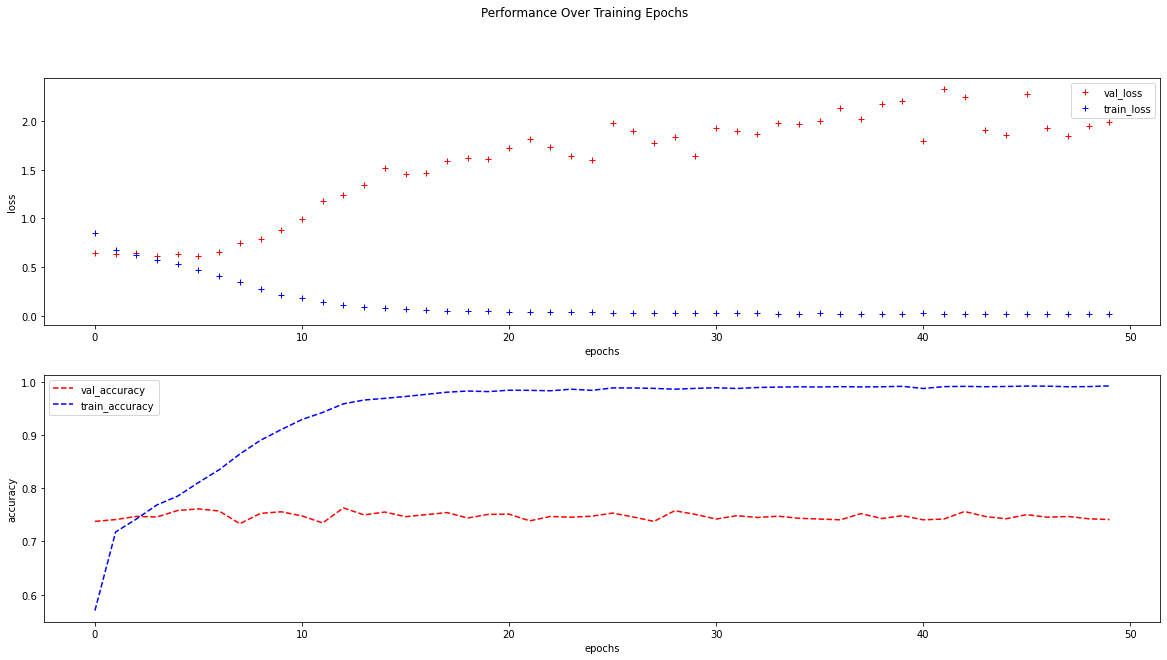

In [8]:
plt.style.use('seaborn-deep')
def plot_training(history):
    histo=history.history
    fig,(ax,ax2)=plt.subplots(figsize=(20,10),nrows=2)
    ax.plot(histo["val_loss"],"r+")
    ax.plot(histo["loss"],"b+")
    ax2.plot(histo["val_accuracy"],"r--")
    ax2.plot(histo["accuracy"],"b--")
    ax.legend(["val_loss","train_loss"])
    ax2.legend(["val_accuracy","train_accuracy"])
    ax.set_xlabel("epochs")
    ax2.set_xlabel("epochs")
    ax.set_ylabel("loss")
    ax2.set_ylabel("accuracy")
    plt.suptitle("Performance Over Training Epochs")
plot_training(history)    

In [46]:
gen_dict=train_generator.class_indices
hand=open(base+"datagen_dict_new","wb")
pickle.dump(gen_dict,hand)
hand.close()

100%|██████████| 11/11 [00:04<00:00,  2.72it/s]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


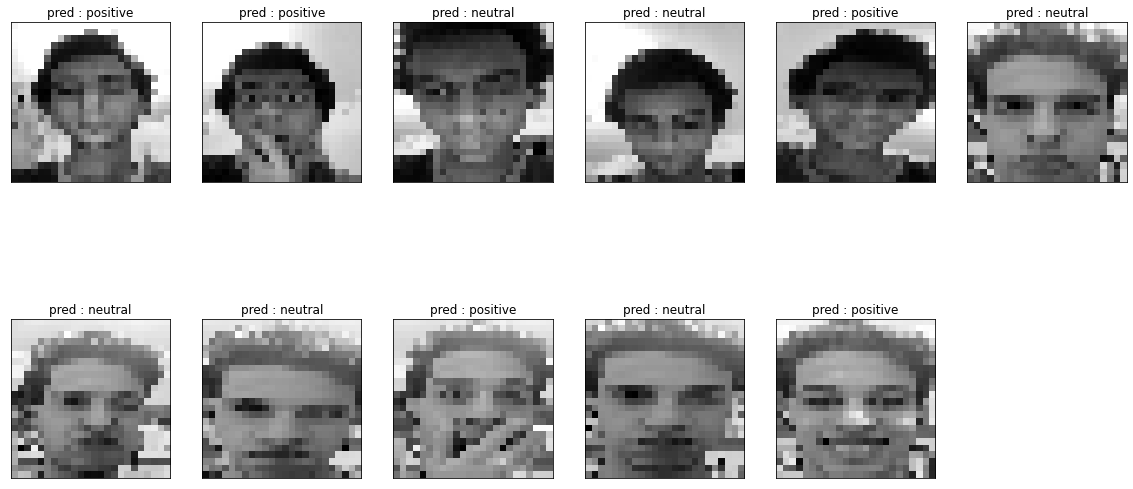

In [9]:

def map_back(preds):  
  preds_str=[]
  key_list=list(gen_dict.keys())
  value_list=list(gen_dict.values())
  for i in preds:
    preds_str.append(key_list[value_list.index(i)])
  return preds_str
def test(model,size):  
  test_im=os.listdir(base+"WhatsApp Unknown 2020-08-22 at 5.44.32 PM")
  base_test=base+"WhatsApp Unknown 2020-08-22 at 5.44.32 PM/"
  test_arr=np.array([])
  for i in tqdm(test_im):
    im=imread(base_test+i)
    im=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    im=cv2.resize(im,(size,size),interpolation=cv2.INTER_NEAREST)
    test_arr=np.append(test_arr,im)
  test_arr=test_arr.reshape(11,size,size,1)
  preds=model.predict_classes(test_arr)
  preds_str=map_back(preds)
  cnt=0
  fig=plt.figure(figsize=(20,10))
  for i in test_arr.reshape(11,size,size):
    ax=plt.subplot(2,6,cnt+1,xticks=[],yticks=[])
    plt.imshow(i,cmap="gray")
    ax.set_title(f"pred : {preds_str[cnt]}")
    cnt+=1
test(model,24)    

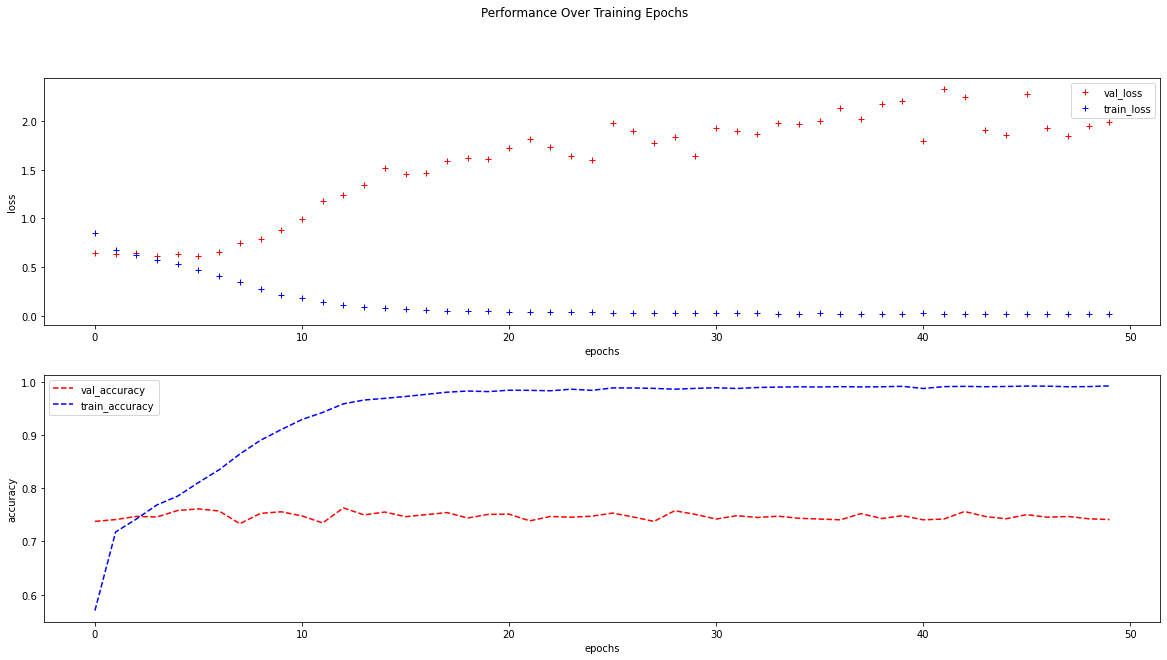

In [10]:
plot_training(history)

Epoch 1/4
181/181 [==============================] - 18s 97ms/step - loss: 0.8093 - accuracy: 0.6150 - val_loss: 0.6886 - val_accuracy: 0.7358
Epoch 2/4
181/181 [==============================] - 17s 95ms/step - loss: 0.6679 - accuracy: 0.7223 - val_loss: 0.6254 - val_accuracy: 0.7603
Epoch 3/4
181/181 [==============================] - 17s 94ms/step - loss: 0.6193 - accuracy: 0.7399 - val_loss: 0.6236 - val_accuracy: 0.7622
Epoch 4/4
181/181 [==============================] - 17s 97ms/step - loss: 0.5833 - accuracy: 0.7596 - val_loss: 0.5935 - val_accuracy: 0.7642


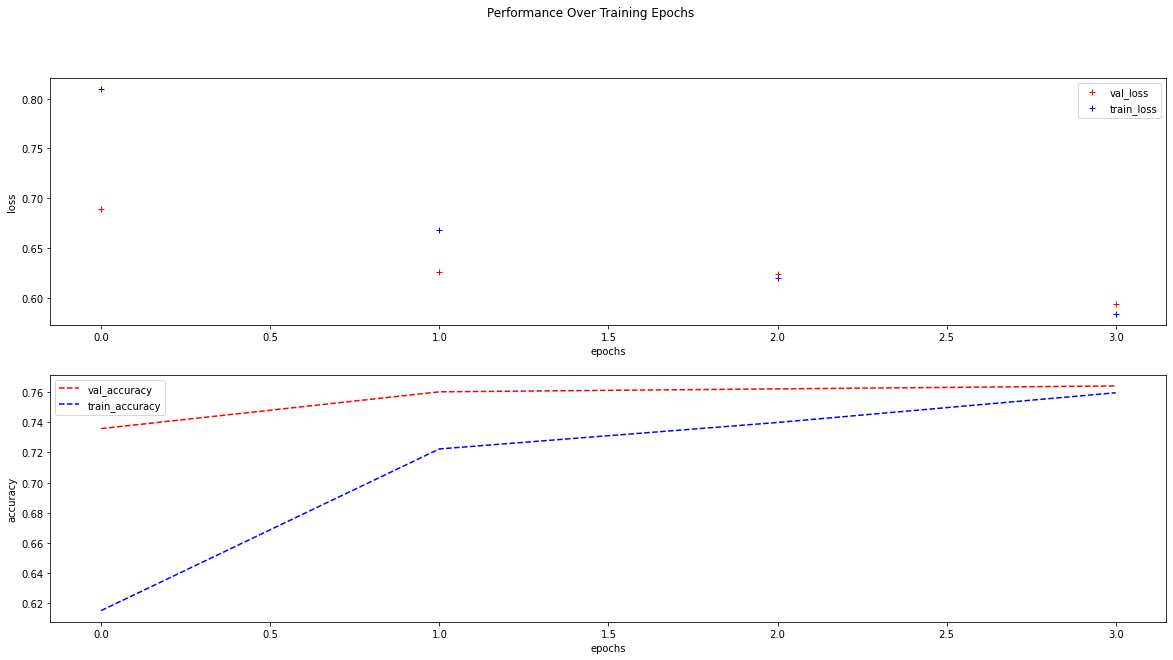

In [13]:
# ok our model is highly overfitting let us try to retrain it with less epochs and more dropout
model=Sequential()
model.add(L.Conv2D(24, kernel_size=(2, 2), input_shape=(24,24, 1), activation='relu', padding='same'))
model.add(L.Dropout(0.2))
model.add(L.Conv2D(56, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(L.Dropout(0.2))
model.add(L.MaxPool2D((2,2)))
model.add(L.Conv2D(128, kernel_size=(3 ,3), activation='relu', padding='same'))
model.add(L.Dropout(0.2))
model.add(L.MaxPool2D((2,2)))
model.add(L.Flatten())
model.add(L.Dense(1000,activation="relu"))
model.add(L.Dropout(0.2))
model.add(L.Dense(100,activation="relu"))
model.add(L.Dropout(0.2))
model.add(L.Dense(3,activation="softmax"))

mc=ModelCheckpoint("best_model_24_b.h5",monitor="val_accuracy",mode="max")
callbacks=[mc]



model.compile(optimizer=keras.optimizers.Adam(0.001),loss="categorical_crossentropy",metrics=["accuracy"])
history=model.fit(
    train_generator,
    steps_per_epoch=len(train_generator.filenames)//batch_size,
    epochs=4,
    validation_data=val_generator,
    validation_steps=len(val_generator.filenames) // batch_size,verbose=1,callbacks=callbacks)
plot_training(history)

In [14]:
model.save(base+"best_model_24_b_best.h5")

100%|██████████| 11/11 [00:00<00:00, 68.71it/s]


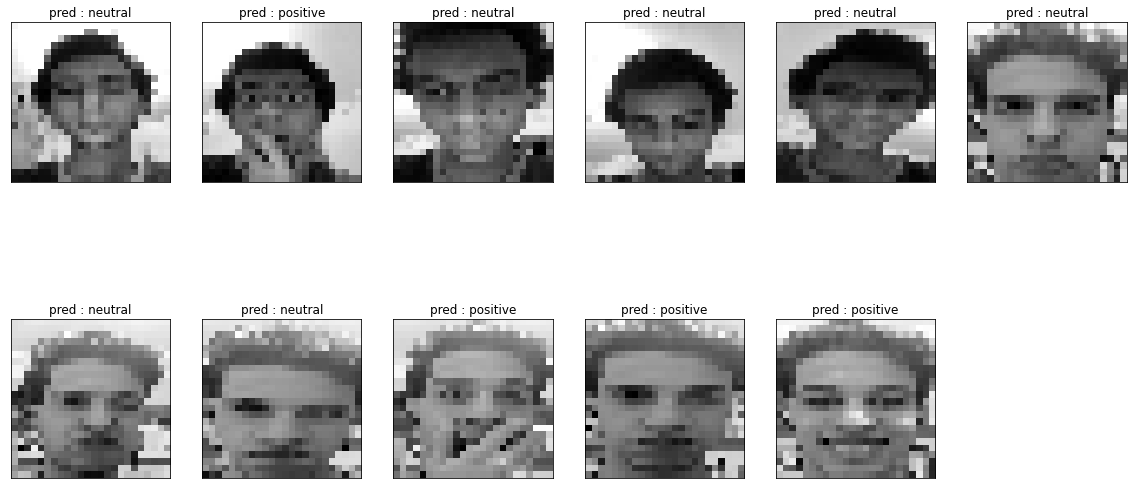

In [15]:
test(model,24)

In [41]:
# now with our model performing better than on validation we will start our progressive resizing path 
batch_size=64
datagen = kp.ImageDataGenerator(fill_mode='nearest',validation_split=0.15)
train_generator=datagen.flow_from_dataframe(dataframe=labels_3,directory=base+"new_images",x_col="image",y_col="emotion",
                                          target_size=(120,120),color_mode="grayscale",batch_size=batch_size,interpolation="nearest",
                                          subset="training")

val_generator=datagen.flow_from_dataframe(dataframe=labels_3,directory=base+"new_images",x_col="image",y_col="emotion",
                                          target_size=(120,120),color_mode="grayscale",batch_size=batch_size,interpolation="nearest",
                                          subset="validation")

Found 11617 validated image filenames belonging to 3 classes.
Found 2049 validated image filenames belonging to 3 classes.


In [42]:
model_120 = Sequential()
model_120.add(L.Conv2D(16, kernel_size=(2, 2), input_shape=(120,120,1), activation='relu', padding='same',name="conv120_1"))
model_120.add(L.Dropout(0.2,name="drop_120_1"))
model_120.add(L.Conv2D(24, kernel_size=(2, 2), activation='relu', padding='same',name="conv120_2"))
model_120.add(L.Dropout(0.2,name="drop_120_2"))
model_120.add(L.MaxPooling2D(pool_size=(5, 5),name="pool_120_1"))

ep=EarlyStopping(monitor="accuracy",mode="max",patience=3,verbose=1,
                 restore_best_weights=True)
mc=ModelCheckpoint(base+"best_model_120_bb2.h5",monitor="val_accuracy",mode="max")
def append_model(new,old):
  for layer in old.layers[1:]:
      if layer in old.layers[:-1]:
          layer.trainable=False
      else:
          layer.trainable=True
      new.add(layer)
  return new    
model_120=append_model(model_120,model)
model_120.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv120_1 (Conv2D)           (None, 120, 120, 16)      80        
_________________________________________________________________
drop_120_1 (Dropout)         (None, 120, 120, 16)      0         
_________________________________________________________________
conv120_2 (Conv2D)           (None, 120, 120, 24)      1560      
_________________________________________________________________
drop_120_2 (Dropout)         (None, 120, 120, 24)      0         
_________________________________________________________________
pool_120_1 (MaxPooling2D)    (None, 24, 24, 24)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 24, 24, 24)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 56)      

Epoch 1/11
181/181 [==============================] - 20s 110ms/step - loss: 0.6586 - accuracy: 0.7185 - val_loss: 0.6598 - val_accuracy: 0.7822
Epoch 2/11
181/181 [==============================] - 20s 109ms/step - loss: 0.5532 - accuracy: 0.7717 - val_loss: 0.6452 - val_accuracy: 0.7812
Epoch 3/11
181/181 [==============================] - 20s 108ms/step - loss: 0.5409 - accuracy: 0.7819 - val_loss: 0.6460 - val_accuracy: 0.7783
Epoch 4/11
181/181 [==============================] - 19s 106ms/step - loss: 0.5369 - accuracy: 0.7795 - val_loss: 0.6511 - val_accuracy: 0.7729
Epoch 5/11
181/181 [==============================] - 19s 105ms/step - loss: 0.5289 - accuracy: 0.7836 - val_loss: 0.6423 - val_accuracy: 0.7847
Epoch 6/11
181/181 [==============================] - 19s 107ms/step - loss: 0.5302 - accuracy: 0.7868 - val_loss: 0.6434 - val_accuracy: 0.7861
Epoch 7/11
181/181 [==============================] - 20s 109ms/step - loss: 0.5317 - accuracy: 0.7866 - val_loss: 0.6261 - val_ac

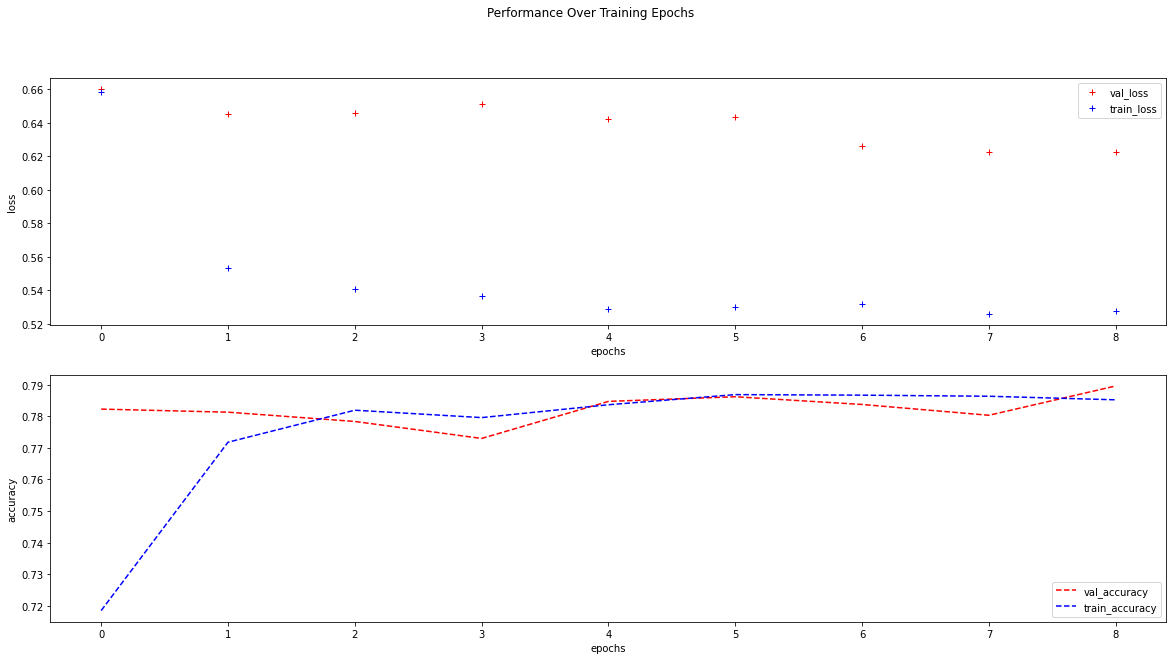

In [43]:
callbacks=[mc,ep]
model_120.compile(optimizer=keras.optimizers.Adam(0.001),loss="categorical_crossentropy",metrics=["accuracy"])
history_120=model_120.fit(
    train_generator,
    steps_per_epoch=len(train_generator.filenames)//batch_size,
    epochs=11,
    validation_data=val_generator,
    validation_steps=len(val_generator.filenames) // batch_size,verbose=1,callbacks=callbacks)
plot_training(history_120)

In [47]:
# more progressive resizing!!!!

datagen = kp.ImageDataGenerator(fill_mode='nearest',validation_split=0.15)
train_generator=datagen.flow_from_dataframe(dataframe=labels_3,directory=base+"new_images",x_col="image",y_col="emotion",
                                          target_size=(360,360),color_mode="grayscale",batch_size=batch_size,interpolation="nearest",
                                          subset="training")

val_generator=datagen.flow_from_dataframe(dataframe=labels_3,directory=base+"new_images",x_col="image",y_col="emotion",
                                          target_size=(360,360),color_mode="grayscale",batch_size=batch_size,interpolation="nearest",
                                          subset="validation")

Found 11617 validated image filenames belonging to 3 classes.
Found 2049 validated image filenames belonging to 3 classes.


Epoch 1/20
181/181 [==============================] - 69s 380ms/step - loss: 0.6293 - accuracy: 0.7331 - val_loss: 0.6461 - val_accuracy: 0.7812
Epoch 2/20
181/181 [==============================] - 68s 374ms/step - loss: 0.5414 - accuracy: 0.7784 - val_loss: 0.6322 - val_accuracy: 0.7798
Epoch 3/20
181/181 [==============================] - 67s 372ms/step - loss: 0.5380 - accuracy: 0.7792 - val_loss: 0.6346 - val_accuracy: 0.7822
Epoch 4/20
181/181 [==============================] - 68s 373ms/step - loss: 0.5335 - accuracy: 0.7837 - val_loss: 0.6570 - val_accuracy: 0.7852
Epoch 5/20
181/181 [==============================] - 68s 374ms/step - loss: 0.5319 - accuracy: 0.7792 - val_loss: 0.6496 - val_accuracy: 0.7876
Epoch 6/20
181/181 [==============================] - 67s 372ms/step - loss: 0.5283 - accuracy: 0.7819 - val_loss: 0.6236 - val_accuracy: 0.7896
Epoch 7/20
181/181 [==============================] - 68s 374ms/step - loss: 0.5244 - accuracy: 0.7840 - val_loss: 0.6324 - val_ac

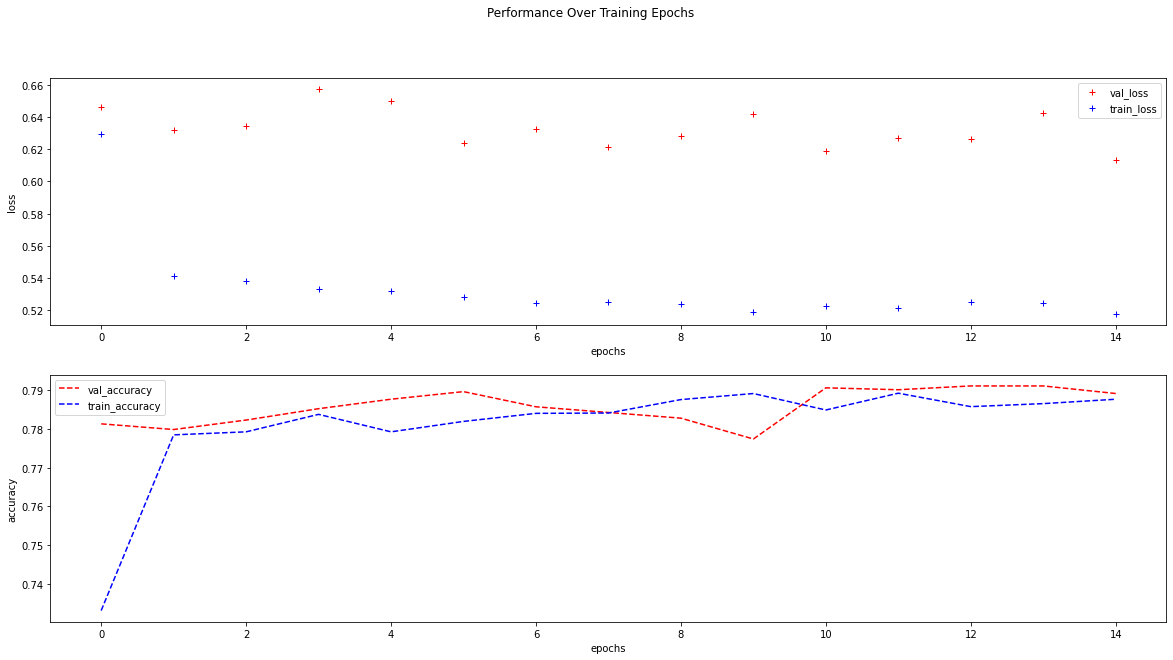

In [49]:
model_360 = Sequential()
model_360.add(L.Conv2D(8, kernel_size=(2, 2), input_shape=(360, 360, 1), activation='relu', padding='same',name="conv360_0"))
model_360.add(L.Conv2D(16, kernel_size=(2, 2), activation='tanh', padding='same',name="conv360_1"))
model_360.add(L.Conv2D(16, kernel_size=(2, 2), activation='tanh', padding='same',name="conv360_2"))
model_360.add(L.Conv2D(16, kernel_size=(2, 2), activation='relu', padding='same',name="conv360_3"))
model_360.add(L.MaxPooling2D(pool_size=(3, 3),name="pool_360_1"))
model_360=append_model(model_360,model_120)

mc=ModelCheckpoint(base+"best_model_360_bb.h5",monitor="val_accuracy",mode="max")

model_360.compile(optimizer=keras.optimizers.Adam(0.001),loss="categorical_crossentropy",metrics=["accuracy"])
history_360=model_360.fit(
    train_generator,
    steps_per_epoch=len(train_generator.filenames)//batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator.filenames) // batch_size,verbose=1,callbacks=callbacks)
plot_training(history_360)

ok the model with 360 by 360 input did increase our accurcay , let us this time train the last model in progressive reszing but account for class weights


In [13]:
gen_dict=train_generator.class_indices
labels_num=labels_3.copy()
labels_num.emotion=labels_num.emotion.map(gen_dict)
class_weights=dict(labels_num.emotion.value_counts())
def create_class_weight(labels_dict,mu=0.5):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

class_weights=create_class_weight(class_weights)
gen_dict,labels_num.emotion.value_counts(),class_weights  

({'negative': 0, 'neutral': 1, 'positive': 2}, 1    6856
 2    5685
 0    1125
 Name: emotion, dtype: int64, {0: 1.8039807801422578, 1: 1.0, 2: 1.0})

In [52]:
model_360.save(base+"best_model_360_bb2.h5")

In [5]:
model_360=keras.models.load_model(base+"best_model_360_bb2.h5")

In [7]:
batch_size=16
datagen = kp.ImageDataGenerator(fill_mode='nearest',validation_split=0.15)
train_generator=datagen.flow_from_dataframe(dataframe=labels_3,directory=base+"new_images",x_col="image",y_col="emotion",
                                          target_size=(1080,1080),color_mode="grayscale",batch_size=batch_size,interpolation="nearest",
                                          subset="training")

val_generator=datagen.flow_from_dataframe(dataframe=labels_3,directory=base+"new_images",x_col="image",y_col="emotion",
                                          target_size=(1080,1080),color_mode="grayscale",batch_size=batch_size,interpolation="nearest",
                                          subset="validation")

Found 11617 validated image filenames belonging to 3 classes.
Found 2049 validated image filenames belonging to 3 classes.


In [ ]:
model_1080 = Sequential()
model_1080.add(L.Conv2D(4, kernel_size=(5, 5), input_shape=(1080, 1080, 1), activation='relu', padding='same',name="conv80_0"))
model_1080.add(L.Conv2D(8, kernel_size=(4, 4), activation='tanh', padding='same',name="conv80_1"))
model_1080.add(L.Conv2D(8, kernel_size=(4, 4), activation='relu', padding='same',name="conv80_2"))
model_1080.add(L.MaxPool2D(3,3))
model_1080=append_model(model_1080,model_360)

ep=EarlyStopping(monitor="accuracy",mode="max",patience=3,verbose=1,
                 restore_best_weights=True)
mc=ModelCheckpoint(base+"best_model_1080_bb.h5",monitor="val_accuracy",mode="max")

callbacks=[ep,mc]
model_1080.compile(optimizer=keras.optimizers.Adam(0.001),loss="categorical_crossentropy",metrics=["accuracy"])
history_1080=model_1080.fit(
    train_generator,
    steps_per_epoch=len(train_generator.filenames)//batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator.filenames) // batch_size,verbose=1,callbacks=callbacks,class_weight=class_weights)
plot_training(history_1080)

Epoch 1/20
726/726 [==============================] - 365s 503ms/step - loss: 0.6471 - accuracy: 0.7776 - val_loss: 0.7003 - val_accuracy: 0.7803
Epoch 2/20
726/726 [==============================] - 366s 504ms/step - loss: 0.6297 - accuracy: 0.7798 - val_loss: 0.7092 - val_accuracy: 0.7783
Epoch 3/20
624/726 [========================>.....] - ETA: 48s - loss: 0.6314 - accuracy: 0.7810

In [9]:
def append_model(new,old):
  for layer in old.layers[1:]:
      if layer in old.layers[:-1]:
          layer.trainable=False
      else:
          layer.trainable=True
      new.add(layer)
  return new 